In [2]:
import yfinance as yf
import numpy as np
import pandas as pd
import talib as ta
import matplotlib.pyplot as plt

from tensorflow.keras import optimizers, models
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

# import cal_def

In [96]:
scale = MinMaxScaler(feature_range=(0, 1))

def sklearn_scaled(data, feature):
    # scale = MinMaxScaler(feature_range=(0, 1))
    for i in feature:
        data[i] = scale.fit_transform(data[i].values.reshape(-1, 1))
    return data

def split_data(data, data_range, train_ratio=0.8):
    split_range = int(len(data) * train_ratio)

    # features = [
    #     "RSI", "SMA_30", "SMA_120", "BB_upper", "SMA_210"
    #     "BB_middle", "BB_lower", "ADOSC", "close_price"
    # ]
    # features = [
    #     'SMA_30', 'SMA_120', 'SMA_210', 'RSI', 'MACD', 'MACD_Signal',
    #     'BB_upper', 'BB_middle', 'BB_lower', 'Momentum', 'Volatility', 'Stochastic',
    #     "ADOSC", "OBV", "AD"
    # ]
    features = [
        'SMA_30', 'SMA_120', 'BB_upper', 'BB_middle', 'BB_lower',
        "AD", 'Volatility', "close_price", "high_price", "low_price",
        "open_price",
    ]
    data = sklearn_scaled(data, features)
    tmp = data["Target"].tolist()
    data = sklearn_scaled(data, ["Target"])
    pre_close = data["Close"]["GC=F"].to_numpy()
    pre_close = (pre_close - min(tmp)) / (max(tmp) - min(tmp))

    pre_x_train = data.iloc[:split_range].loc[:,features]
    pre_y_train = data.iloc[:split_range].loc[:,["Target"]]
    pre_x_test = data.iloc[split_range:].loc[:,features]
    pre_y_test = data.iloc[split_range:].loc[:,["Target"]]
    pre_date = data.iloc[split_range:].index.to_list()
    pre_close = pre_close[split_range:]
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    date = []
    close = []
    for i in range(len(pre_x_train)-data_range):
        # x_tmp = np.transpose(pre_x_train.iloc[i:i+data_range].to_numpy())
        x_tmp = pre_x_train.iloc[i:i+data_range].to_numpy()
        y_tmp = pre_y_train.iloc[i+data_range-1].to_numpy()
        x_train.append(x_tmp)
        y_train.append(y_tmp)

    for i in range(len(pre_x_test)-data_range):
        # x_tmp = np.transpose(pre_x_test.iloc[i:i+data_range].to_numpy())
        x_tmp = pre_x_test.iloc[i:i+data_range].to_numpy()
        y_tmp = pre_y_test.iloc[i+data_range-1].to_numpy()
        x_test.append(x_tmp)
        y_test.append(y_tmp)
        date.append(pre_date[i+data_range-1])
        close.append(pre_close[i+data_range-1])
    x_train = np.array(x_train)
    y_train = np.array(y_train).reshape(-1)
    x_test = np.array(x_test)
    y_test = np.array(y_test).reshape(-1)
    # close = np.array(close)
    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape, len(date), len(close))
    return x_train, y_train, x_test, y_test, date, close

def prepar_data(asset, start, end, target_date):
    data = yf.download(asset, start=start, end=end)
    data.dropna(inplace=True)

    # momentum indicator
    data['RSI'] = ta.RSI(data['Close'][asset[0]], timeperiod=14)
    data['MACD'], data['MACD_Signal'], _ = ta.MACD(data['Close'][asset[0]], fastperiod=12, slowperiod=26, signalperiod=9)
    data['Momentum'] = ta.MOM(data['Close'][asset[0]], timeperiod=10)
    data['Stochastic'] = ta.STOCH(data['High'][asset[0]], data['Low'][asset[0]], data['Close'][asset[0]], fastk_period=14, slowk_period=3)[0]

    # volatility indicator
    data['Volatility'] = ta.ATR(data['High'][asset[0]], data['Low'][asset[0]], data['Close'][asset[0]], timeperiod=14)
    data["NATR"] = ta.NATR(data['High'][asset[0]], data['Low'][asset[0]], data['Close'][asset[0]], timeperiod=14)

    # overlap studies functions
    data['SMA_30'] = ta.MA(data['Close'][asset[0]], timeperiod=30)
    data['SMA_120'] = ta.MA(data['Close'][asset[0]], timeperiod=120)
    data['SMA_210'] = ta.MA(data['Close'][asset[0]], timeperiod=210)
    data['BB_upper'], data['BB_middle'], data['BB_lower'] = ta.BBANDS(data['Close'][asset[0]], timeperiod=20)
    
    # volume indicator
    data["AD"] = ta.AD(data["High"][asset[1]], data["Low"][asset[1]], data["Close"][asset[1]], data["Volume"][asset[1]])
    data["ADOSC"] = ta.ADOSC(data["High"][asset[1]], data["Low"][asset[1]], data["Close"][asset[1]], data["Volume"][asset[1]], fastperiod=3, slowperiod=10)
    data["OBV"] = ta.OBV(data["Close"][asset[1]], data["Volume"][asset[1]])

    # intail
    data["close_price"] = data["Close"][asset[0]]
    data["high_price"] = data["High"][asset[0]]
    data["low_price"] = data["Low"][asset[0]]
    data["open_price"] = data["Open"][asset[0]]

    # target of predict
    data["Target"] = data["Close"][asset[0]].shift(-target_date)

    data.dropna(inplace=True)
    return data

def moment(data):
    indicator = ["RSI", "MACD", "Momentum", "Stochastic"]
    data = data[indicator].to_numpy()
    data_min = np.min(data)
    data_max = np.max(data)
    data = (data - data_min) / (data_max - data_min)
    return data

def overlap(data):
    indicator = ['SMA_30', 'SMA_120', 'SMA_210', 'BB_upper', 'BB_middle', 'BB_lower', 'close_price', 'high_price', 'low_price', 'open_price', 'Target']
    data = data[indicator].to_numpy()
    data_min = np.min(data)
    data_max = np.max(data)
    data = (data - data_min) / (data_max - data_min)
    return data

def scaled_data(data):
    scaled_mm = moment(data)
    scale_ov = overlap(data)
    # print(scaled_mm.shape, scale_ov.shape)
    scale = np.concatenate((scaled_mm, scale_ov), axis=1)
    # print(scale.shape)
    # print(scaled_mm)
    return scale

def split(data, size, range_day, close):
    row, col = data.shape
    row = int(row * size)
    X = data[:, :col-1]
    Y = data[:, -1]
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    close_test = []
    for i in range(row - range_day):
        x_train.append(X[i:i+range_day])
        y_train.append(Y[i+range_day-1])
        x_test.append(X[row+i:row+i+range_day])
        y_test.append(Y[row+i+range_day-1])
        close_test.append(close[row+i+range_day-1])
    x_train = np.array(x_train)
    y_train = np.array(y_train)
    x_test = np.array(x_test)
    y_test = np.array(y_test)
    return x_train, y_train, x_test, y_test, close_test

def model_lstm(range_input=30, neurons=30, n_feature=3):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(range_input, n_feature), return_sequences=False))
    model.add(LSTM(int(neurons/2), return_sequences=True))
    model.add(Dense(1, activation="linear"))
    model.compile(loss='mean_squared_error', optimizer=optimizers.Adam())
    return model

In [97]:
vol = ["^GSPC", "^NDX", "FNV", "ITA", "NOC", "PPA", "QQQ", "XAR"]
asset = ["GC=F", vol[0]]
taget_date = 1
range_date = 30
data = prepar_data(asset, '2014-01-01', '2024-12-01', taget_date)

[*********************100%***********************]  2 of 2 completed


In [98]:
scale_data = scaled_data(data)
x_train, y_train, x_test, y_test, close_test = split(scale_data, 0.5, range_date, data["close_price"].to_numpy())

In [89]:
print(x_train.shape)

(1236, 30, 14)


In [99]:
model = model_lstm(range_input=x_train.shape[1], neurons=200, n_feature=x_train.shape[2])
history = model.fit(x_train, y_train, batch_size=200, epochs=200, verbose=2)
# print(history)
plt.plot(history.history["loss"])

d:\co_op\venv\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Input 0 of layer "lstm_9" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 200)

39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step


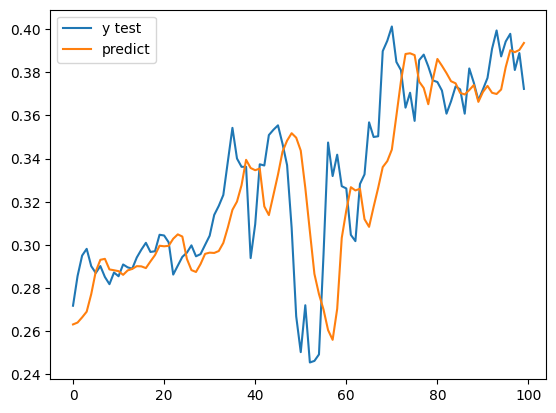

In [91]:
predict = model.predict(x_test)
plt.plot(y_test[:100], label="y test")
plt.plot(predict[:100], label="predict")
plt.legend()

In [78]:
print(len(close_test))

1237


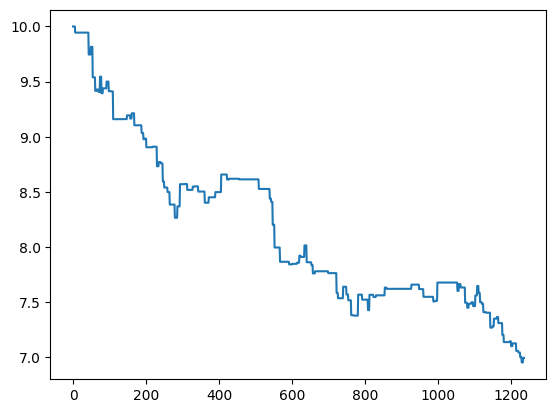

In [93]:
capital = 10
open_status = False
count_day = 0
capital_history = [capital]
for i in range(len(close_test) - 1):
    today_c = close_test[i]
    future_c = close_test[i+1]

    today_p = x_test[i, range_date-1, -1]
    future_p = predict[i]
    diff_change = future_p - today_p
    if open_status:
        count_day += 1
        if count_day == taget_date:
            open_status = False
    elif abs(diff_change) > 0.01:
        open_status = True
        count_day = 0
        capital *= 0.999
        if diff_change > 0:
            profit = (future_c - today_c) / today_c * capital
        else:
            profit = (today_c - future_c) / today_c * capital
        capital += profit
        capital *= 0.999
    capital_history.append(capital)
plt.plot(capital_history)


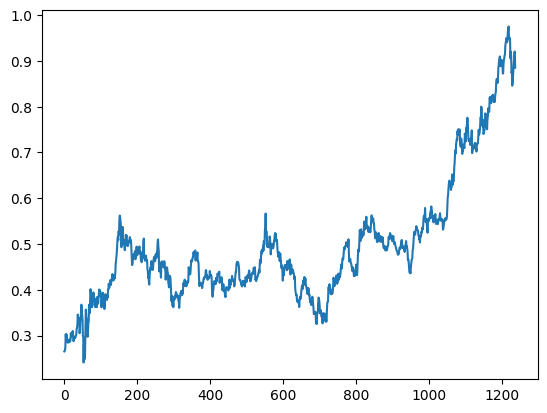

In [80]:
plt.plot(x_test[:, range_date-1, -1])

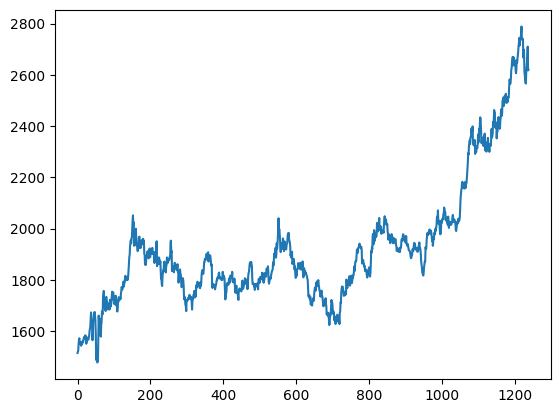

In [81]:
plt.plot(close_test)

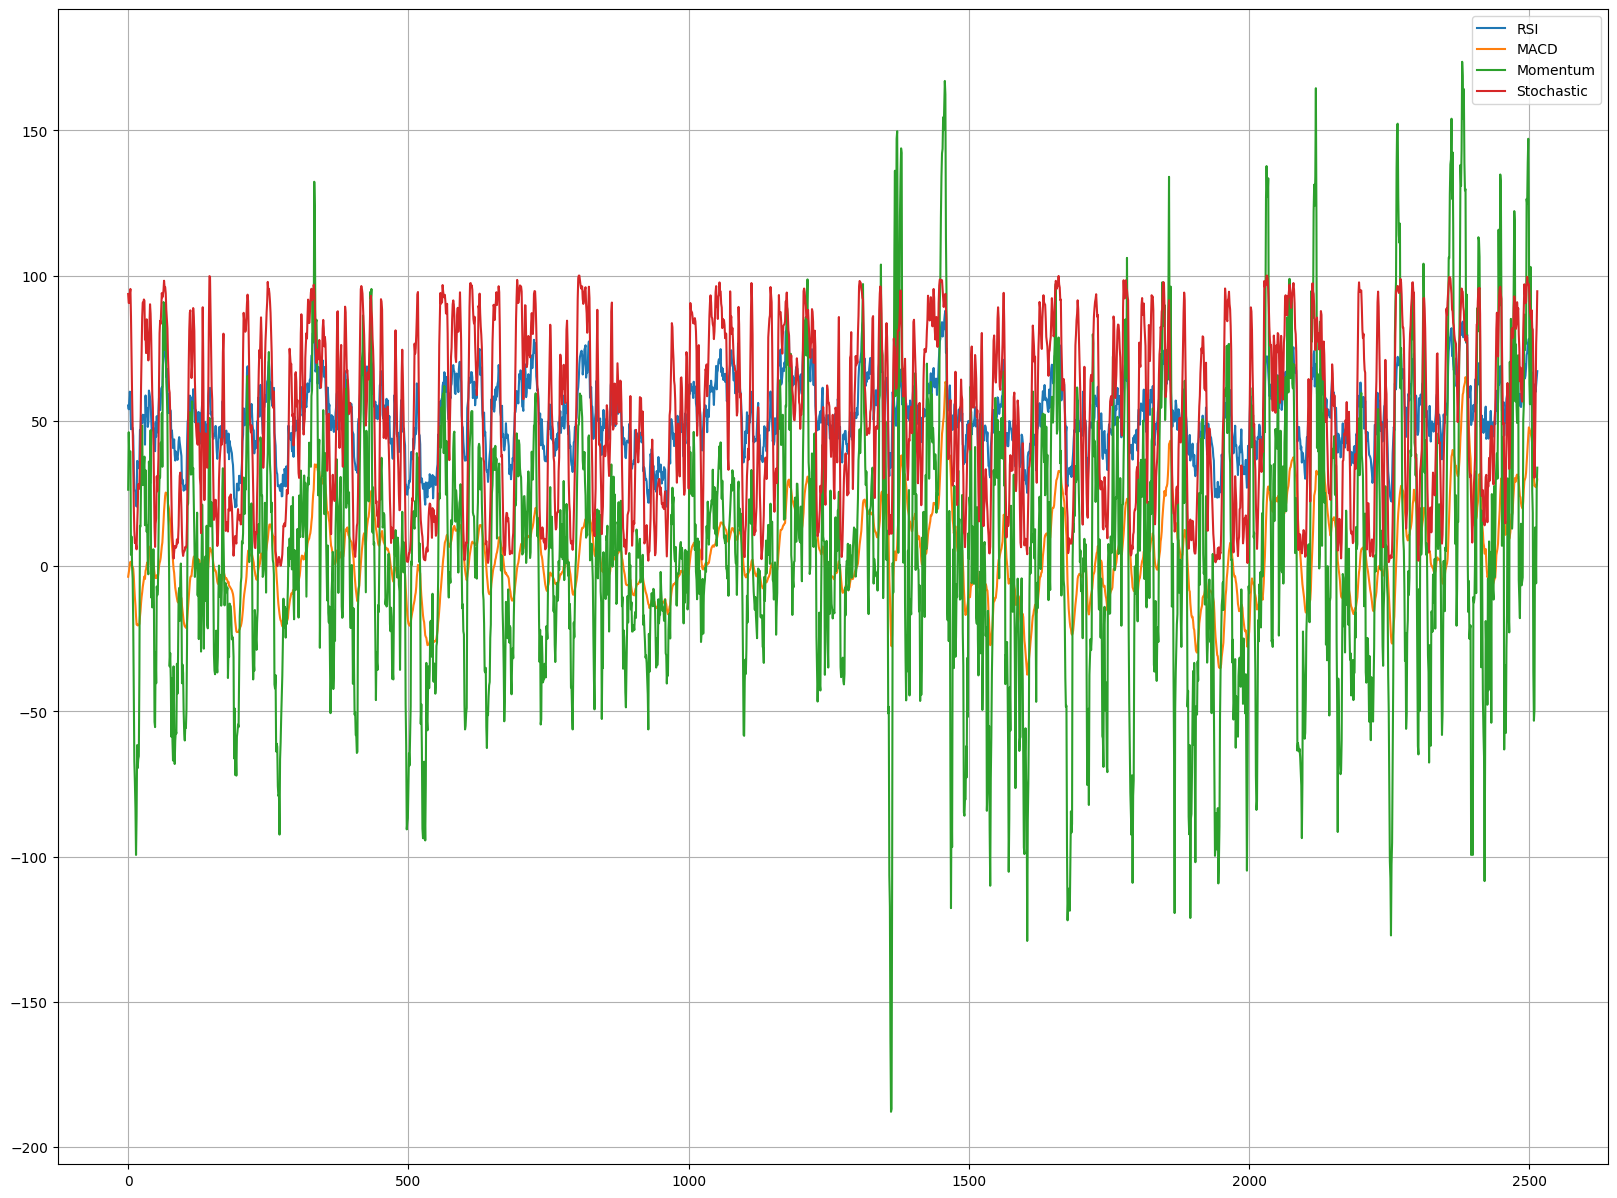

In [39]:
plt.figure(figsize=(20, 15))
# plt.plot(data["close_price"].to_numpy()-1200, label="open")
plt.plot(data["RSI"].to_numpy(), label="RSI")
plt.plot(data["MACD"].to_numpy(), label="MACD")
plt.plot(data["Momentum"].to_numpy(), label="Momentum")
plt.plot(data["Stochastic"].to_numpy(), label="Stochastic")
plt.legend()
plt.grid()
plt.show()


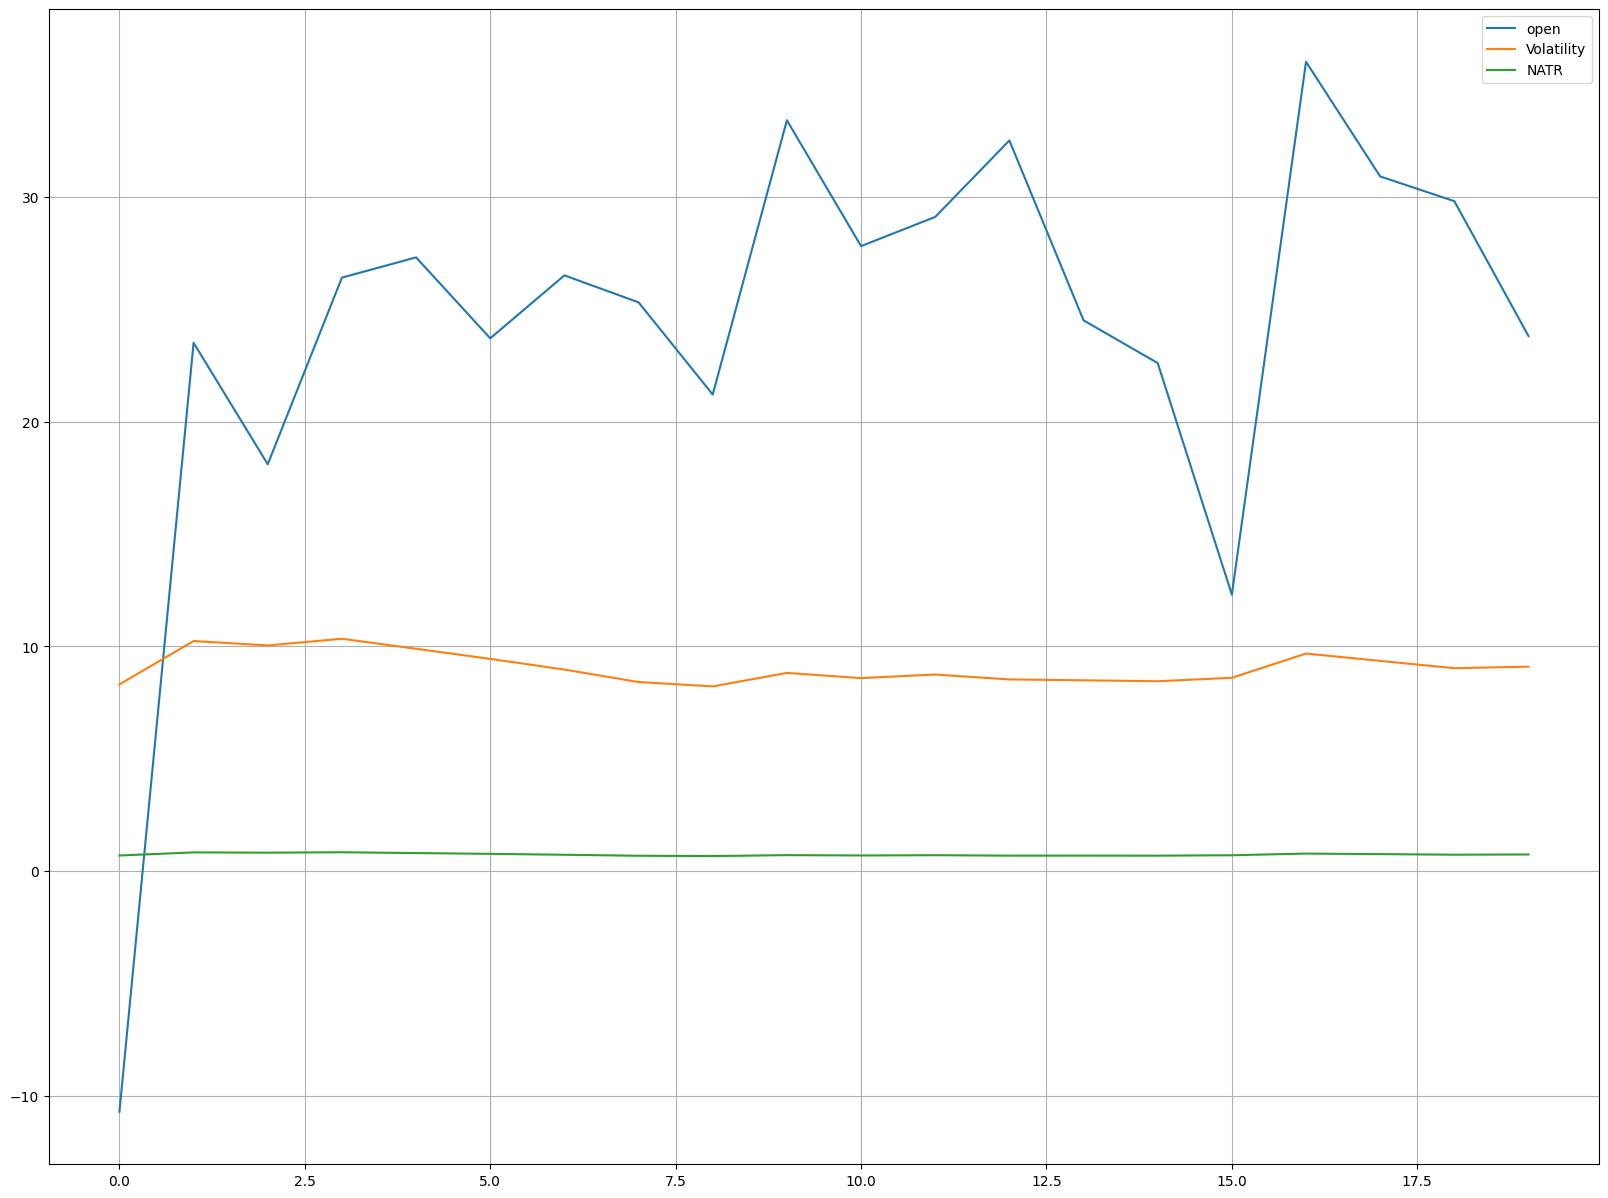

In [22]:
plt.figure(figsize=(20, 15))
plt.plot(data["close_price"][1000:1020].to_numpy()-1200, label="open")
plt.plot(data["Volatility"][1000:1020].to_numpy(), label="Volatility")
plt.plot(data["NATR"][1000:1020].to_numpy(), label="NATR")
plt.legend()
plt.grid()
plt.show()

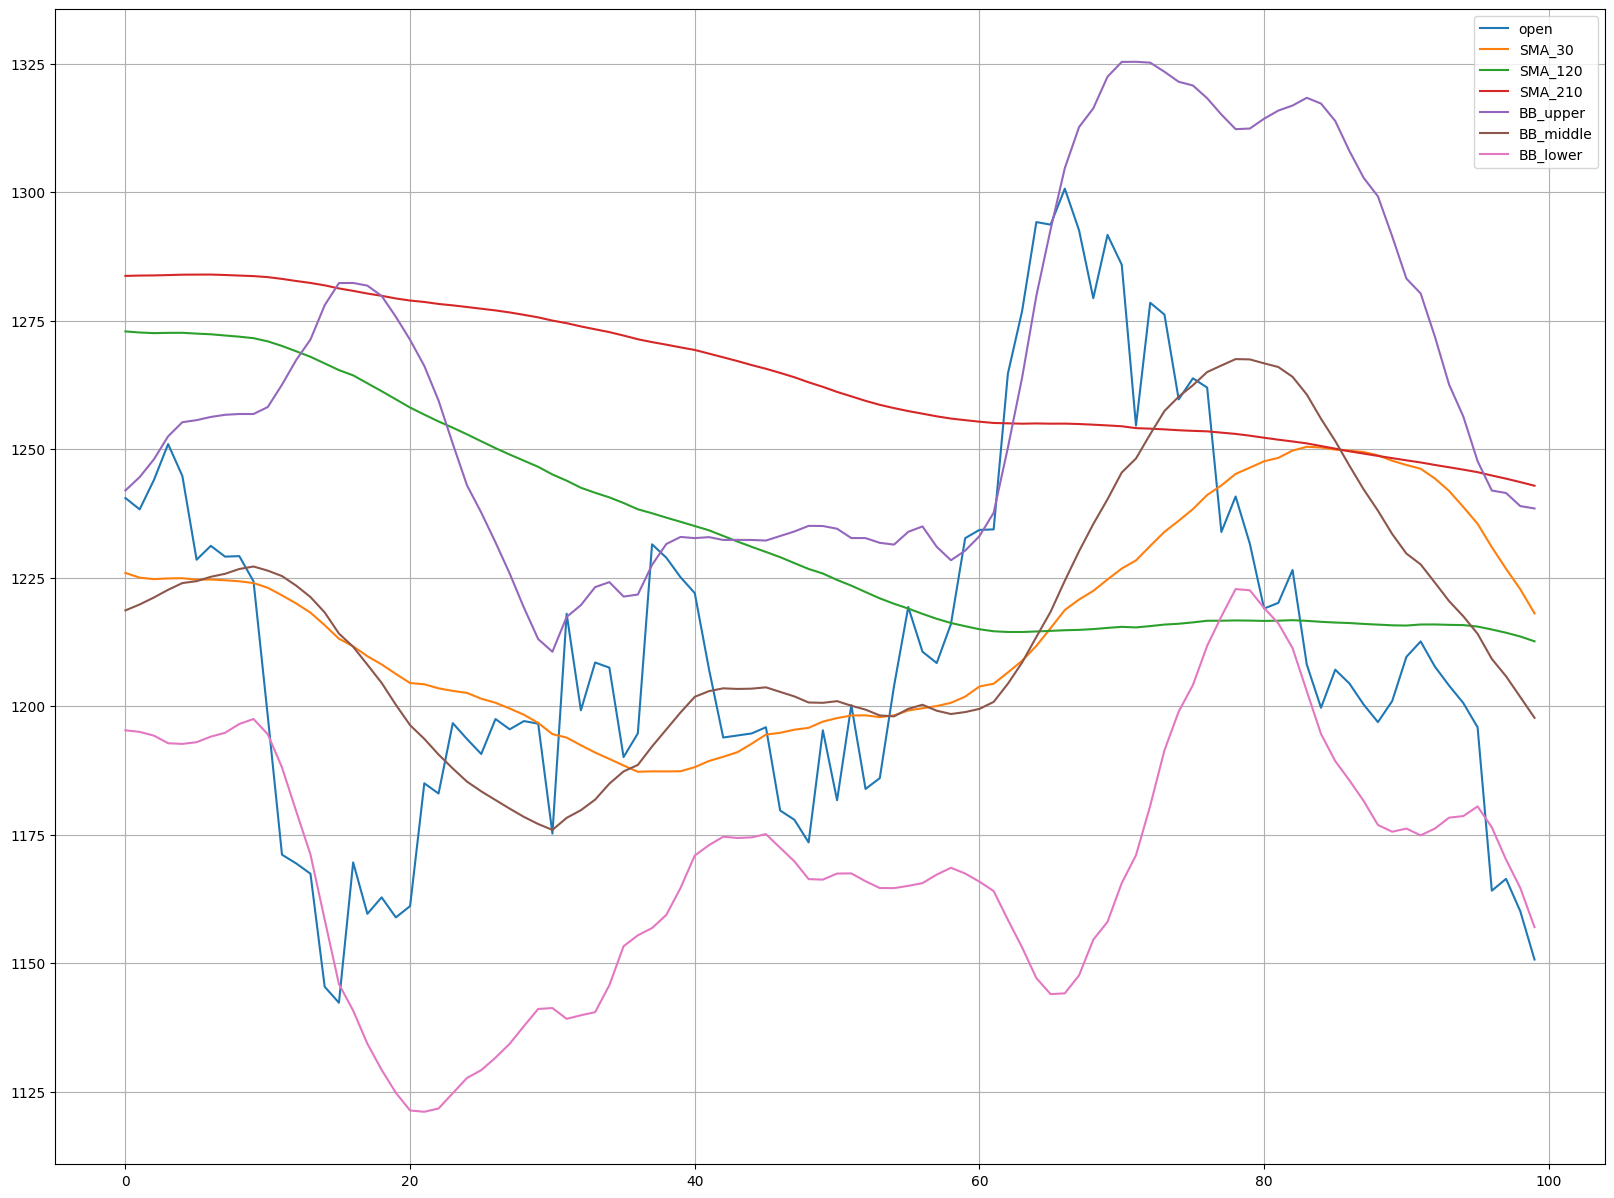

In [25]:
plt.figure(figsize=(20, 15))
plt.plot(data["close_price"][:100].to_numpy(), label="open")
plt.plot(data["SMA_30"][:100].to_numpy(), label="SMA_30")
plt.plot(data["SMA_120"][:100].to_numpy(), label="SMA_120")
plt.plot(data["SMA_210"][:100].to_numpy(), label="SMA_210")
plt.plot(data["BB_upper"][:100].to_numpy(), label="BB_upper")
plt.plot(data["BB_middle"][:100].to_numpy(), label="BB_middle")
plt.plot(data["BB_lower"][:100].to_numpy(), label="BB_lower")

plt.legend()
plt.grid()
plt.show()